<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[04:10:36] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


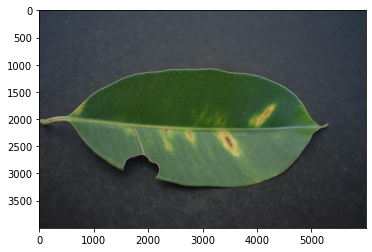

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

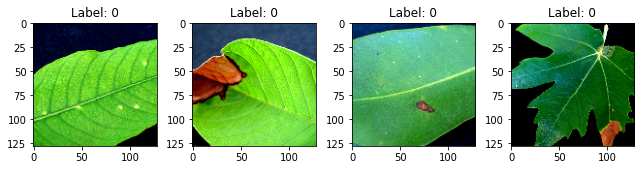

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[04:10:43] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[04:10:45] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2622701278971573 samples/sec                   batch loss = 0.3986842632293701 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2747043247531293 samples/sec                   batch loss = 0.6940321326255798 | accuracy = 0.575


Epoch[1] Batch[15] Speed: 1.2721932186157454 samples/sec                   batch loss = 0.8504374623298645 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.269201542025599 samples/sec                   batch loss = 0.7902034521102905 | accuracy = 0.5


Epoch[1] Batch[25] Speed: 1.264065704953368 samples/sec                   batch loss = 0.6706121563911438 | accuracy = 0.54


Epoch[1] Batch[30] Speed: 1.2730451246459562 samples/sec                   batch loss = 0.9097158908843994 | accuracy = 0.575


Epoch[1] Batch[35] Speed: 1.271700358295466 samples/sec                   batch loss = 0.6027268767356873 | accuracy = 0.5857142857142857


Epoch[1] Batch[40] Speed: 1.271766680778696 samples/sec                   batch loss = 1.4434245824813843 | accuracy = 0.58125


Epoch[1] Batch[45] Speed: 1.274547737758171 samples/sec                   batch loss = 0.5829322338104248 | accuracy = 0.5722222222222222


Epoch[1] Batch[50] Speed: 1.271696791730022 samples/sec                   batch loss = 0.6895992159843445 | accuracy = 0.565


Epoch[1] Batch[55] Speed: 1.2716562114076788 samples/sec                   batch loss = 0.5327761173248291 | accuracy = 0.5772727272727273


Epoch[1] Batch[60] Speed: 1.2746793379775931 samples/sec                   batch loss = 0.4927201271057129 | accuracy = 0.5833333333333334


Epoch[1] Batch[65] Speed: 1.2737198320111425 samples/sec                   batch loss = 0.4482707977294922 | accuracy = 0.5923076923076923


Epoch[1] Batch[70] Speed: 1.2645751584919571 samples/sec                   batch loss = 0.7775479555130005 | accuracy = 0.6035714285714285


Epoch[1] Batch[75] Speed: 1.2717509671231935 samples/sec                   batch loss = 0.7884106636047363 | accuracy = 0.5966666666666667


Epoch[1] Batch[80] Speed: 1.2740702736736365 samples/sec                   batch loss = 0.3791782855987549 | accuracy = 0.60625


Epoch[1] Batch[85] Speed: 1.2780271664688747 samples/sec                   batch loss = 0.4642675518989563 | accuracy = 0.611764705882353


Epoch[1] Batch[90] Speed: 1.2760013005508326 samples/sec                   batch loss = 0.8063180446624756 | accuracy = 0.6166666666666667


Epoch[1] Batch[95] Speed: 1.2712340790911547 samples/sec                   batch loss = 0.4903838336467743 | accuracy = 0.618421052631579


Epoch[1] Batch[100] Speed: 1.277002543620527 samples/sec                   batch loss = 0.6470272541046143 | accuracy = 0.62


Epoch[1] Batch[105] Speed: 1.2737794021961535 samples/sec                   batch loss = 0.8944778442382812 | accuracy = 0.6166666666666667


Epoch[1] Batch[110] Speed: 1.2698849639971774 samples/sec                   batch loss = 0.3668965697288513 | accuracy = 0.6204545454545455


Epoch[1] Batch[115] Speed: 1.26313665536682 samples/sec                   batch loss = 0.447492390871048 | accuracy = 0.6260869565217392


Epoch[1] Batch[120] Speed: 1.2662008719518874 samples/sec                   batch loss = 0.8771417737007141 | accuracy = 0.61875


Epoch[1] Batch[125] Speed: 1.2738402352940998 samples/sec                   batch loss = 0.522270917892456 | accuracy = 0.626


Epoch[1] Batch[130] Speed: 1.2704340403182124 samples/sec                   batch loss = 0.7145191431045532 | accuracy = 0.6307692307692307


Epoch[1] Batch[135] Speed: 1.2745275982532884 samples/sec                   batch loss = 0.6896505951881409 | accuracy = 0.6314814814814815


Epoch[1] Batch[140] Speed: 1.2707889326063335 samples/sec                   batch loss = 0.45293253660202026 | accuracy = 0.6357142857142857


Epoch[1] Batch[145] Speed: 1.270602993592084 samples/sec                   batch loss = 0.37300610542297363 | accuracy = 0.6379310344827587


Epoch[1] Batch[150] Speed: 1.2722245717036844 samples/sec                   batch loss = 0.48608076572418213 | accuracy = 0.6383333333333333


Epoch[1] Batch[155] Speed: 1.2726978533428237 samples/sec                   batch loss = 0.72849440574646 | accuracy = 0.6370967741935484


Epoch[1] Batch[160] Speed: 1.271288311398203 samples/sec                   batch loss = 0.41587069630622864 | accuracy = 0.6421875


Epoch[1] Batch[165] Speed: 1.2683166086329392 samples/sec                   batch loss = 0.419305682182312 | accuracy = 0.6439393939393939


Epoch[1] Batch[170] Speed: 1.2712401474852963 samples/sec                   batch loss = 0.48550111055374146 | accuracy = 0.6485294117647059


Epoch[1] Batch[175] Speed: 1.2712021968927967 samples/sec                   batch loss = 0.45540851354599 | accuracy = 0.6571428571428571


Epoch[1] Batch[180] Speed: 1.2781447826774264 samples/sec                   batch loss = 0.516144335269928 | accuracy = 0.6611111111111111


Epoch[1] Batch[185] Speed: 1.2753173885618645 samples/sec                   batch loss = 0.7444373369216919 | accuracy = 0.6635135135135135


Epoch[1] Batch[190] Speed: 1.2666382192007108 samples/sec                   batch loss = 0.9792859554290771 | accuracy = 0.6592105263157895


Epoch[1] Batch[195] Speed: 1.2723447889403818 samples/sec                   batch loss = 1.023212194442749 | accuracy = 0.6615384615384615


Epoch[1] Batch[200] Speed: 1.274643505939434 samples/sec                   batch loss = 0.2402428686618805 | accuracy = 0.66375


Epoch[1] Batch[205] Speed: 1.2709733855069385 samples/sec                   batch loss = 0.7091109752655029 | accuracy = 0.6609756097560976


Epoch[1] Batch[210] Speed: 1.2652832819443527 samples/sec                   batch loss = 0.6555947065353394 | accuracy = 0.6595238095238095


Epoch[1] Batch[215] Speed: 1.2701976196725844 samples/sec                   batch loss = 0.551929771900177 | accuracy = 0.6593023255813953


Epoch[1] Batch[220] Speed: 1.276160768780932 samples/sec                   batch loss = 0.795071542263031 | accuracy = 0.6534090909090909


Epoch[1] Batch[225] Speed: 1.2722387534541175 samples/sec                   batch loss = 0.4901292622089386 | accuracy = 0.6544444444444445


Epoch[1] Batch[230] Speed: 1.2746695565997053 samples/sec                   batch loss = 0.840347170829773 | accuracy = 0.6565217391304348


Epoch[1] Batch[235] Speed: 1.2711240874496657 samples/sec                   batch loss = 0.9386945962905884 | accuracy = 0.6553191489361702


Epoch[1] Batch[240] Speed: 1.2714197211127451 samples/sec                   batch loss = 0.49104955792427063 | accuracy = 0.6520833333333333


Epoch[1] Batch[245] Speed: 1.2708837516532563 samples/sec                   batch loss = 0.7458123564720154 | accuracy = 0.6540816326530612


Epoch[1] Batch[250] Speed: 1.2770546446298858 samples/sec                   batch loss = 0.46487852931022644 | accuracy = 0.652


Epoch[1] Batch[255] Speed: 1.2692039424172983 samples/sec                   batch loss = 0.38175928592681885 | accuracy = 0.653921568627451


Epoch[1] Batch[260] Speed: 1.2680660235391503 samples/sec                   batch loss = 0.8797667622566223 | accuracy = 0.6519230769230769


Epoch[1] Batch[265] Speed: 1.268017528451991 samples/sec                   batch loss = 0.26986610889434814 | accuracy = 0.6528301886792452


Epoch[1] Batch[270] Speed: 1.2646179571779657 samples/sec                   batch loss = 0.39727404713630676 | accuracy = 0.6537037037037037


Epoch[1] Batch[275] Speed: 1.2675868900095235 samples/sec                   batch loss = 0.7698426842689514 | accuracy = 0.6536363636363637


Epoch[1] Batch[280] Speed: 1.2745563553369053 samples/sec                   batch loss = 0.3847396969795227 | accuracy = 0.6553571428571429


Epoch[1] Batch[285] Speed: 1.2646897396515495 samples/sec                   batch loss = 0.22107547521591187 | accuracy = 0.6552631578947369


Epoch[1] Batch[290] Speed: 1.2738904342287833 samples/sec                   batch loss = 0.5522733330726624 | accuracy = 0.6525862068965518


Epoch[1] Batch[295] Speed: 1.2710349138045327 samples/sec                   batch loss = 0.2767057716846466 | accuracy = 0.6550847457627119


Epoch[1] Batch[300] Speed: 1.2684761757580139 samples/sec                   batch loss = 0.7788749933242798 | accuracy = 0.6583333333333333


Epoch[1] Batch[305] Speed: 1.265508044362286 samples/sec                   batch loss = 0.7388666272163391 | accuracy = 0.6598360655737705


Epoch[1] Batch[310] Speed: 1.261648288389368 samples/sec                   batch loss = 0.4338533878326416 | accuracy = 0.6612903225806451


Epoch[1] Batch[315] Speed: 1.2730577790970807 samples/sec                   batch loss = 0.8295474052429199 | accuracy = 0.6611111111111111


Epoch[1] Batch[320] Speed: 1.2748444819176843 samples/sec                   batch loss = 0.9074455499649048 | accuracy = 0.659375


Epoch[1] Batch[325] Speed: 1.2730827023395372 samples/sec                   batch loss = 0.5790709257125854 | accuracy = 0.6607692307692308


Epoch[1] Batch[330] Speed: 1.2711714720577725 samples/sec                   batch loss = 0.4616382122039795 | accuracy = 0.6628787878787878


Epoch[1] Batch[335] Speed: 1.2686553530411342 samples/sec                   batch loss = 0.4002908170223236 | accuracy = 0.6619402985074627


Epoch[1] Batch[340] Speed: 1.2723631226181418 samples/sec                   batch loss = 0.43128231167793274 | accuracy = 0.663235294117647


Epoch[1] Batch[345] Speed: 1.2735463752560041 samples/sec                   batch loss = 0.7533899545669556 | accuracy = 0.6644927536231884


Epoch[1] Batch[350] Speed: 1.2666931120777563 samples/sec                   batch loss = 0.7223197221755981 | accuracy = 0.6657142857142857


Epoch[1] Batch[355] Speed: 1.268509072290023 samples/sec                   batch loss = 0.7848491072654724 | accuracy = 0.6661971830985915


Epoch[1] Batch[360] Speed: 1.2706028011368253 samples/sec                   batch loss = 0.32469719648361206 | accuracy = 0.6666666666666666


Epoch[1] Batch[365] Speed: 1.2735220138771652 samples/sec                   batch loss = 0.4287797212600708 | accuracy = 0.6671232876712329


Epoch[1] Batch[370] Speed: 1.270492533860496 samples/sec                   batch loss = 0.7402752041816711 | accuracy = 0.6682432432432432


Epoch[1] Batch[375] Speed: 1.2704097016646643 samples/sec                   batch loss = 0.7332168221473694 | accuracy = 0.6666666666666666


Epoch[1] Batch[380] Speed: 1.2667301244206373 samples/sec                   batch loss = 0.8463821411132812 | accuracy = 0.6651315789473684


Epoch[1] Batch[385] Speed: 1.269025762018337 samples/sec                   batch loss = 0.6049075126647949 | accuracy = 0.6655844155844156


Epoch[1] Batch[390] Speed: 1.2650212077015628 samples/sec                   batch loss = 0.3945687413215637 | accuracy = 0.6673076923076923


Epoch[1] Batch[395] Speed: 1.2701697320716037 samples/sec                   batch loss = 0.4348466098308563 | accuracy = 0.6677215189873418


Epoch[1] Batch[400] Speed: 1.269585720223899 samples/sec                   batch loss = 1.0582886934280396 | accuracy = 0.66875


Epoch[1] Batch[405] Speed: 1.267118549698511 samples/sec                   batch loss = 1.3376927375793457 | accuracy = 0.6691358024691358


Epoch[1] Batch[410] Speed: 1.2737539681400858 samples/sec                   batch loss = 0.8113014698028564 | accuracy = 0.6670731707317074


Epoch[1] Batch[415] Speed: 1.2678223396987114 samples/sec                   batch loss = 0.5294347405433655 | accuracy = 0.6662650602409639


Epoch[1] Batch[420] Speed: 1.2697925043320506 samples/sec                   batch loss = 0.8476670980453491 | accuracy = 0.6648809523809524


Epoch[1] Batch[425] Speed: 1.2619804420748506 samples/sec                   batch loss = 0.4473446309566498 | accuracy = 0.6641176470588235


Epoch[1] Batch[430] Speed: 1.2681217112083298 samples/sec                   batch loss = 0.471335768699646 | accuracy = 0.6651162790697674


Epoch[1] Batch[435] Speed: 1.273791104137251 samples/sec                   batch loss = 0.6162533164024353 | accuracy = 0.6649425287356322


Epoch[1] Batch[440] Speed: 1.2741627767748263 samples/sec                   batch loss = 0.29841914772987366 | accuracy = 0.6670454545454545


Epoch[1] Batch[445] Speed: 1.2712555595403596 samples/sec                   batch loss = 0.6425504684448242 | accuracy = 0.6685393258426966


Epoch[1] Batch[450] Speed: 1.2736348380989326 samples/sec                   batch loss = 0.2614368498325348 | accuracy = 0.6705555555555556


Epoch[1] Batch[455] Speed: 1.2657155074520616 samples/sec                   batch loss = 0.5397105813026428 | accuracy = 0.6697802197802197


Epoch[1] Batch[460] Speed: 1.2751858504153364 samples/sec                   batch loss = 0.5561392307281494 | accuracy = 0.6706521739130434


Epoch[1] Batch[465] Speed: 1.2753724545901948 samples/sec                   batch loss = 0.4037211537361145 | accuracy = 0.6720430107526881


Epoch[1] Batch[470] Speed: 1.2773262997162615 samples/sec                   batch loss = 0.24660581350326538 | accuracy = 0.6718085106382978


Epoch[1] Batch[475] Speed: 1.2631879163781419 samples/sec                   batch loss = 0.341197669506073 | accuracy = 0.6726315789473685


Epoch[1] Batch[480] Speed: 1.273670226677282 samples/sec                   batch loss = 0.5993925929069519 | accuracy = 0.6708333333333333


Epoch[1] Batch[485] Speed: 1.276990879797864 samples/sec                   batch loss = 0.22123362123966217 | accuracy = 0.6737113402061856


Epoch[1] Batch[490] Speed: 1.2666299952421771 samples/sec                   batch loss = 0.6657695770263672 | accuracy = 0.6729591836734694


Epoch[1] Batch[495] Speed: 1.2651419754254785 samples/sec                   batch loss = 1.3195713758468628 | accuracy = 0.6727272727272727


Epoch[1] Batch[500] Speed: 1.26182117628619 samples/sec                   batch loss = 0.5318090319633484 | accuracy = 0.6715


Epoch[1] Batch[505] Speed: 1.2712767517262642 samples/sec                   batch loss = 0.8609461784362793 | accuracy = 0.6712871287128713


Epoch[1] Batch[510] Speed: 1.2709143663061813 samples/sec                   batch loss = 1.0104721784591675 | accuracy = 0.671078431372549


Epoch[1] Batch[515] Speed: 1.280751808503313 samples/sec                   batch loss = 0.3156845271587372 | accuracy = 0.670873786407767


Epoch[1] Batch[520] Speed: 1.2710058339606083 samples/sec                   batch loss = 0.30832746624946594 | accuracy = 0.6730769230769231


Epoch[1] Batch[525] Speed: 1.2708526571477288 samples/sec                   batch loss = 0.7454448342323303 | accuracy = 0.6733333333333333


Epoch[1] Batch[530] Speed: 1.2732424081328004 samples/sec                   batch loss = 0.5051615834236145 | accuracy = 0.6745283018867925


Epoch[1] Batch[535] Speed: 1.272717838514918 samples/sec                   batch loss = 0.8028814196586609 | accuracy = 0.6761682242990654


Epoch[1] Batch[540] Speed: 1.2709794514124229 samples/sec                   batch loss = 0.41729506850242615 | accuracy = 0.6773148148148148


Epoch[1] Batch[545] Speed: 1.2689628924085048 samples/sec                   batch loss = 0.2341403216123581 | accuracy = 0.6779816513761467


Epoch[1] Batch[550] Speed: 1.2703019686284807 samples/sec                   batch loss = 0.49015480279922485 | accuracy = 0.68


Epoch[1] Batch[555] Speed: 1.2758852428360046 samples/sec                   batch loss = 0.8183293342590332 | accuracy = 0.6792792792792792


Epoch[1] Batch[560] Speed: 1.2676871705393205 samples/sec                   batch loss = 0.5893064737319946 | accuracy = 0.6794642857142857


Epoch[1] Batch[565] Speed: 1.273337303748855 samples/sec                   batch loss = 0.3107474446296692 | accuracy = 0.6805309734513274


Epoch[1] Batch[570] Speed: 1.2689156723097907 samples/sec                   batch loss = 0.48393192887306213 | accuracy = 0.6820175438596491


Epoch[1] Batch[575] Speed: 1.2669684132687953 samples/sec                   batch loss = 0.9483062028884888 | accuracy = 0.6808695652173913


Epoch[1] Batch[580] Speed: 1.2725578781862934 samples/sec                   batch loss = 0.2050819993019104 | accuracy = 0.6818965517241379


Epoch[1] Batch[585] Speed: 1.2736031254153846 samples/sec                   batch loss = 0.34345951676368713 | accuracy = 0.6824786324786325


Epoch[1] Batch[590] Speed: 1.2707666979033263 samples/sec                   batch loss = 0.6037469506263733 | accuracy = 0.6830508474576271


Epoch[1] Batch[595] Speed: 1.2695104990352237 samples/sec                   batch loss = 0.6169106960296631 | accuracy = 0.684453781512605


Epoch[1] Batch[600] Speed: 1.2782285292637576 samples/sec                   batch loss = 0.42836543917655945 | accuracy = 0.685


Epoch[1] Batch[605] Speed: 1.2773632552921155 samples/sec                   batch loss = 0.9190454483032227 | accuracy = 0.6838842975206612


Epoch[1] Batch[610] Speed: 1.2747425815982028 samples/sec                   batch loss = 0.37428709864616394 | accuracy = 0.684016393442623


Epoch[1] Batch[615] Speed: 1.2770932371106931 samples/sec                   batch loss = 0.5446583032608032 | accuracy = 0.6849593495934959


Epoch[1] Batch[620] Speed: 1.2699014005446192 samples/sec                   batch loss = 0.4660332500934601 | accuracy = 0.6862903225806452


Epoch[1] Batch[625] Speed: 1.2721741181073762 samples/sec                   batch loss = 0.4701882600784302 | accuracy = 0.686


Epoch[1] Batch[630] Speed: 1.2723692982917163 samples/sec                   batch loss = 0.5257828831672668 | accuracy = 0.6861111111111111


Epoch[1] Batch[635] Speed: 1.2704882043841388 samples/sec                   batch loss = 0.31760174036026 | accuracy = 0.6874015748031496


Epoch[1] Batch[640] Speed: 1.2670392188789057 samples/sec                   batch loss = 0.630958616733551 | accuracy = 0.688671875


Epoch[1] Batch[645] Speed: 1.2654317784393778 samples/sec                   batch loss = 0.491314560174942 | accuracy = 0.6883720930232559


Epoch[1] Batch[650] Speed: 1.2643737861919229 samples/sec                   batch loss = 0.3999222218990326 | accuracy = 0.688076923076923


Epoch[1] Batch[655] Speed: 1.2693395312802633 samples/sec                   batch loss = 0.8769901990890503 | accuracy = 0.6885496183206107


Epoch[1] Batch[660] Speed: 1.2698012499400189 samples/sec                   batch loss = 0.27494338154792786 | accuracy = 0.6890151515151515


Epoch[1] Batch[665] Speed: 1.2607458090529355 samples/sec                   batch loss = 1.3622853755950928 | accuracy = 0.6890977443609022


Epoch[1] Batch[670] Speed: 1.2592766784466354 samples/sec                   batch loss = 0.3365415930747986 | accuracy = 0.6895522388059702


Epoch[1] Batch[675] Speed: 1.2696204037487715 samples/sec                   batch loss = 0.44117826223373413 | accuracy = 0.6888888888888889


Epoch[1] Batch[680] Speed: 1.2728685681683773 samples/sec                   batch loss = 0.48382797837257385 | accuracy = 0.6893382352941176


Epoch[1] Batch[685] Speed: 1.2685865729057382 samples/sec                   batch loss = 0.475787878036499 | accuracy = 0.6901459854014599


Epoch[1] Batch[690] Speed: 1.2766123100762123 samples/sec                   batch loss = 0.5307486057281494 | accuracy = 0.691304347826087


Epoch[1] Batch[695] Speed: 1.2765398477393735 samples/sec                   batch loss = 0.9836357831954956 | accuracy = 0.6906474820143885


Epoch[1] Batch[700] Speed: 1.2730888850003574 samples/sec                   batch loss = 0.5518366694450378 | accuracy = 0.6896428571428571


Epoch[1] Batch[705] Speed: 1.2713621055916402 samples/sec                   batch loss = 0.1687811315059662 | accuracy = 0.6900709219858157


Epoch[1] Batch[710] Speed: 1.2692749020971703 samples/sec                   batch loss = 0.6541850566864014 | accuracy = 0.6904929577464789


Epoch[1] Batch[715] Speed: 1.2741764211513145 samples/sec                   batch loss = 0.5276511311531067 | accuracy = 0.6898601398601398


Epoch[1] Batch[720] Speed: 1.2782706014575465 samples/sec                   batch loss = 0.4659929573535919 | accuracy = 0.6888888888888889


Epoch[1] Batch[725] Speed: 1.2673232863293407 samples/sec                   batch loss = 1.0533442497253418 | accuracy = 0.6882758620689655


Epoch[1] Batch[730] Speed: 1.2735381580200862 samples/sec                   batch loss = 1.5996350049972534 | accuracy = 0.6886986301369863


Epoch[1] Batch[735] Speed: 1.2694022461252783 samples/sec                   batch loss = 0.5838290452957153 | accuracy = 0.6891156462585034


Epoch[1] Batch[740] Speed: 1.2702948511963803 samples/sec                   batch loss = 0.3763614594936371 | accuracy = 0.6902027027027027


Epoch[1] Batch[745] Speed: 1.2763552322397231 samples/sec                   batch loss = 0.5369016528129578 | accuracy = 0.6909395973154362


Epoch[1] Batch[750] Speed: 1.279768987012995 samples/sec                   batch loss = 0.43620309233665466 | accuracy = 0.6913333333333334


Epoch[1] Batch[755] Speed: 1.2792617541573756 samples/sec                   batch loss = 0.3084222376346588 | accuracy = 0.6913907284768211


Epoch[1] Batch[760] Speed: 1.2735288775046776 samples/sec                   batch loss = 0.4271608889102936 | accuracy = 0.6904605263157895


Epoch[1] Batch[765] Speed: 1.2724134947053733 samples/sec                   batch loss = 0.3056718111038208 | accuracy = 0.6915032679738562


Epoch[1] Batch[770] Speed: 1.2666539980248093 samples/sec                   batch loss = 0.47940942645072937 | accuracy = 0.6918831168831169


Epoch[1] Batch[775] Speed: 1.2652949237265574 samples/sec                   batch loss = 0.6291497349739075 | accuracy = 0.69


Epoch[1] Batch[780] Speed: 1.268445870258945 samples/sec                   batch loss = 0.5803123712539673 | accuracy = 0.6887820512820513


Epoch[1] Batch[785] Speed: 1.2654018091158743 samples/sec                   batch loss = 0.6613617539405823 | accuracy = 0.689171974522293


[Epoch 1] training: accuracy=0.688769035532995
[Epoch 1] time cost: 647.1144189834595
[Epoch 1] validation: validation accuracy=0.7622222222222222


Epoch[2] Batch[5] Speed: 1.2680811670338514 samples/sec                   batch loss = 0.7582072019577026 | accuracy = 0.6


Epoch[2] Batch[10] Speed: 1.2721899386896818 samples/sec                   batch loss = 0.6800639629364014 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.272469275348051 samples/sec                   batch loss = 0.5023092031478882 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.2656437994474148 samples/sec                   batch loss = 0.16487029194831848 | accuracy = 0.8125


Epoch[2] Batch[25] Speed: 1.2720834467505309 samples/sec                   batch loss = 0.21845002472400665 | accuracy = 0.78


Epoch[2] Batch[30] Speed: 1.2726962120763865 samples/sec                   batch loss = 0.6414270997047424 | accuracy = 0.7833333333333333


Epoch[2] Batch[35] Speed: 1.2700414648778668 samples/sec                   batch loss = 0.30454570055007935 | accuracy = 0.7785714285714286


Epoch[2] Batch[40] Speed: 1.2700354079223692 samples/sec                   batch loss = 0.40559709072113037 | accuracy = 0.78125


Epoch[2] Batch[45] Speed: 1.2678597055009229 samples/sec                   batch loss = 0.6011556386947632 | accuracy = 0.7833333333333333


Epoch[2] Batch[50] Speed: 1.2711292880267482 samples/sec                   batch loss = 0.8668352365493774 | accuracy = 0.78


Epoch[2] Batch[55] Speed: 1.2744772522754866 samples/sec                   batch loss = 0.3570833206176758 | accuracy = 0.7818181818181819


Epoch[2] Batch[60] Speed: 1.270312741109856 samples/sec                   batch loss = 0.47016939520835876 | accuracy = 0.7791666666666667


Epoch[2] Batch[65] Speed: 1.272407511605061 samples/sec                   batch loss = 0.13414901494979858 | accuracy = 0.7884615384615384


Epoch[2] Batch[70] Speed: 1.2729032381415988 samples/sec                   batch loss = 0.5626052021980286 | accuracy = 0.7964285714285714


Epoch[2] Batch[75] Speed: 1.2743943837128768 samples/sec                   batch loss = 0.7697454690933228 | accuracy = 0.7933333333333333


Epoch[2] Batch[80] Speed: 1.2724522897209978 samples/sec                   batch loss = 0.28747549653053284 | accuracy = 0.7875


Epoch[2] Batch[85] Speed: 1.267055390459423 samples/sec                   batch loss = 1.5235850811004639 | accuracy = 0.7676470588235295


Epoch[2] Batch[90] Speed: 1.2643613990769684 samples/sec                   batch loss = 0.5653811097145081 | accuracy = 0.7555555555555555


Epoch[2] Batch[95] Speed: 1.2716976592711267 samples/sec                   batch loss = 0.21637724339962006 | accuracy = 0.7578947368421053


Epoch[2] Batch[100] Speed: 1.2744721210818768 samples/sec                   batch loss = 0.3119763135910034 | accuracy = 0.7525


Epoch[2] Batch[105] Speed: 1.2739020414820355 samples/sec                   batch loss = 0.8289605975151062 | accuracy = 0.75


Epoch[2] Batch[110] Speed: 1.2752817145184434 samples/sec                   batch loss = 0.664669394493103 | accuracy = 0.7477272727272727


Epoch[2] Batch[115] Speed: 1.2688159649887838 samples/sec                   batch loss = 0.6404208540916443 | accuracy = 0.7478260869565218


Epoch[2] Batch[120] Speed: 1.262872522650419 samples/sec                   batch loss = 0.4144340455532074 | accuracy = 0.74375


Epoch[2] Batch[125] Speed: 1.2722947117448193 samples/sec                   batch loss = 0.4123555123806 | accuracy = 0.744


Epoch[2] Batch[130] Speed: 1.2649033240133642 samples/sec                   batch loss = 0.3519202768802643 | accuracy = 0.7480769230769231


Epoch[2] Batch[135] Speed: 1.2651549502650516 samples/sec                   batch loss = 0.406724750995636 | accuracy = 0.7444444444444445


Epoch[2] Batch[140] Speed: 1.2658853092645435 samples/sec                   batch loss = 0.6319881081581116 | accuracy = 0.7392857142857143


Epoch[2] Batch[145] Speed: 1.2697302313979197 samples/sec                   batch loss = 0.4723385274410248 | accuracy = 0.7379310344827587


Epoch[2] Batch[150] Speed: 1.2756586224235194 samples/sec                   batch loss = 0.3582368493080139 | accuracy = 0.7416666666666667


Epoch[2] Batch[155] Speed: 1.2820826800860896 samples/sec                   batch loss = 0.5235059857368469 | accuracy = 0.7419354838709677


Epoch[2] Batch[160] Speed: 1.2693628685461045 samples/sec                   batch loss = 0.23652414977550507 | accuracy = 0.7375


Epoch[2] Batch[165] Speed: 1.2675879434951824 samples/sec                   batch loss = 0.30117446184158325 | accuracy = 0.740909090909091


Epoch[2] Batch[170] Speed: 1.2705683525847293 samples/sec                   batch loss = 0.3133891224861145 | accuracy = 0.7485294117647059


Epoch[2] Batch[175] Speed: 1.2674931367985003 samples/sec                   batch loss = 0.3085826337337494 | accuracy = 0.7485714285714286


Epoch[2] Batch[180] Speed: 1.2717478822793686 samples/sec                   batch loss = 1.5138269662857056 | accuracy = 0.7458333333333333


Epoch[2] Batch[185] Speed: 1.2711085822779726 samples/sec                   batch loss = 1.3870930671691895 | accuracy = 0.7391891891891892


Epoch[2] Batch[190] Speed: 1.2652888165354081 samples/sec                   batch loss = 0.28351232409477234 | accuracy = 0.7394736842105263


Epoch[2] Batch[195] Speed: 1.2715784316638281 samples/sec                   batch loss = 0.517001211643219 | accuracy = 0.7397435897435898


Epoch[2] Batch[200] Speed: 1.2682856396187465 samples/sec                   batch loss = 0.7278115749359131 | accuracy = 0.73875


Epoch[2] Batch[205] Speed: 1.2751661753396661 samples/sec                   batch loss = 0.46932923793792725 | accuracy = 0.7402439024390244


Epoch[2] Batch[210] Speed: 1.261541751554142 samples/sec                   batch loss = 0.2832283675670624 | accuracy = 0.7428571428571429


Epoch[2] Batch[215] Speed: 1.2672048775090081 samples/sec                   batch loss = 0.17723609507083893 | accuracy = 0.7441860465116279


Epoch[2] Batch[220] Speed: 1.2727441967306288 samples/sec                   batch loss = 0.29517558217048645 | accuracy = 0.7454545454545455


Epoch[2] Batch[225] Speed: 1.2687745128511583 samples/sec                   batch loss = 0.36687085032463074 | accuracy = 0.7466666666666667


Epoch[2] Batch[230] Speed: 1.2702406074423316 samples/sec                   batch loss = 0.6087855100631714 | accuracy = 0.7467391304347826


Epoch[2] Batch[235] Speed: 1.2633970930116976 samples/sec                   batch loss = 0.3845905065536499 | accuracy = 0.752127659574468


Epoch[2] Batch[240] Speed: 1.2643762636440397 samples/sec                   batch loss = 0.294780433177948 | accuracy = 0.7520833333333333


Epoch[2] Batch[245] Speed: 1.2741577448799484 samples/sec                   batch loss = 0.8256940841674805 | accuracy = 0.753061224489796


Epoch[2] Batch[250] Speed: 1.2702415691706792 samples/sec                   batch loss = 0.16104041039943695 | accuracy = 0.753


Epoch[2] Batch[255] Speed: 1.2706270509585549 samples/sec                   batch loss = 0.6976585984230042 | accuracy = 0.7509803921568627


Epoch[2] Batch[260] Speed: 1.269956768887648 samples/sec                   batch loss = 0.24675489962100983 | accuracy = 0.7509615384615385


Epoch[2] Batch[265] Speed: 1.2687094614848753 samples/sec                   batch loss = 0.6504246592521667 | accuracy = 0.75


Epoch[2] Batch[270] Speed: 1.2697715538051295 samples/sec                   batch loss = 0.4953906238079071 | accuracy = 0.7490740740740741


Epoch[2] Batch[275] Speed: 1.2709103227769165 samples/sec                   batch loss = 0.5667923092842102 | accuracy = 0.7454545454545455


Epoch[2] Batch[280] Speed: 1.2713691386446684 samples/sec                   batch loss = 1.2239354848861694 | accuracy = 0.7455357142857143


Epoch[2] Batch[285] Speed: 1.2651441696811203 samples/sec                   batch loss = 0.2890915870666504 | accuracy = 0.7429824561403509


Epoch[2] Batch[290] Speed: 1.2734640143453186 samples/sec                   batch loss = 0.2567046284675598 | accuracy = 0.746551724137931


Epoch[2] Batch[295] Speed: 1.27757812624338 samples/sec                   batch loss = 0.9463992118835449 | accuracy = 0.7432203389830508


Epoch[2] Batch[300] Speed: 1.2747159468429703 samples/sec                   batch loss = 0.5397077798843384 | accuracy = 0.7425


Epoch[2] Batch[305] Speed: 1.2609322857190528 samples/sec                   batch loss = 0.16705475747585297 | accuracy = 0.7418032786885246


Epoch[2] Batch[310] Speed: 1.267591487050704 samples/sec                   batch loss = 0.5087038278579712 | accuracy = 0.7419354838709677


Epoch[2] Batch[315] Speed: 1.2723320521700237 samples/sec                   batch loss = 0.5978952646255493 | accuracy = 0.7428571428571429


Epoch[2] Batch[320] Speed: 1.2659712780568961 samples/sec                   batch loss = 0.3480633497238159 | accuracy = 0.74375


Epoch[2] Batch[325] Speed: 1.2650643227574352 samples/sec                   batch loss = 0.13382861018180847 | accuracy = 0.7446153846153846


Epoch[2] Batch[330] Speed: 1.2639481897152993 samples/sec                   batch loss = 1.0230376720428467 | accuracy = 0.7454545454545455


Epoch[2] Batch[335] Speed: 1.269417997841026 samples/sec                   batch loss = 0.579710066318512 | accuracy = 0.744776119402985


Epoch[2] Batch[340] Speed: 1.2736680027469638 samples/sec                   batch loss = 0.7888092398643494 | accuracy = 0.7441176470588236


Epoch[2] Batch[345] Speed: 1.27312830087481 samples/sec                   batch loss = 0.5942294597625732 | accuracy = 0.7471014492753624


Epoch[2] Batch[350] Speed: 1.2667786167321051 samples/sec                   batch loss = 0.17238612473011017 | accuracy = 0.7478571428571429


Epoch[2] Batch[355] Speed: 1.2647357876797007 samples/sec                   batch loss = 0.5186482667922974 | accuracy = 0.7485915492957746


Epoch[2] Batch[360] Speed: 1.2775991405920468 samples/sec                   batch loss = 0.6324341893196106 | accuracy = 0.7486111111111111


Epoch[2] Batch[365] Speed: 1.2776851509643592 samples/sec                   batch loss = 0.3196765184402466 | accuracy = 0.7472602739726028


Epoch[2] Batch[370] Speed: 1.2739637569305104 samples/sec                   batch loss = 0.11909570544958115 | accuracy = 0.745945945945946


Epoch[2] Batch[375] Speed: 1.2671404655119727 samples/sec                   batch loss = 0.23373819887638092 | accuracy = 0.748


Epoch[2] Batch[380] Speed: 1.2717747787650533 samples/sec                   batch loss = 0.39002302289009094 | accuracy = 0.7473684210526316


Epoch[2] Batch[385] Speed: 1.2757250674124991 samples/sec                   batch loss = 0.5090837478637695 | accuracy = 0.7474025974025974


Epoch[2] Batch[390] Speed: 1.2767876718860027 samples/sec                   batch loss = 0.2314683347940445 | accuracy = 0.7480769230769231


Epoch[2] Batch[395] Speed: 1.2721286843544137 samples/sec                   batch loss = 0.9068708419799805 | accuracy = 0.7462025316455696


Epoch[2] Batch[400] Speed: 1.269788275729646 samples/sec                   batch loss = 0.6092329621315002 | accuracy = 0.744375


Epoch[2] Batch[405] Speed: 1.2712070128323048 samples/sec                   batch loss = 0.8684239387512207 | accuracy = 0.7444444444444445


Epoch[2] Batch[410] Speed: 1.2714223226056387 samples/sec                   batch loss = 0.27119556069374084 | accuracy = 0.7426829268292683


Epoch[2] Batch[415] Speed: 1.2659087107236262 samples/sec                   batch loss = 0.6543506383895874 | accuracy = 0.7403614457831326


Epoch[2] Batch[420] Speed: 1.267016923826431 samples/sec                   batch loss = 0.6377255320549011 | accuracy = 0.7404761904761905


Epoch[2] Batch[425] Speed: 1.273035175139674 samples/sec                   batch loss = 0.4408479332923889 | accuracy = 0.7411764705882353


Epoch[2] Batch[430] Speed: 1.270484259775814 samples/sec                   batch loss = 0.21981674432754517 | accuracy = 0.7424418604651163


Epoch[2] Batch[435] Speed: 1.2696421179449575 samples/sec                   batch loss = 0.4385237991809845 | accuracy = 0.743103448275862


Epoch[2] Batch[440] Speed: 1.2743589548826377 samples/sec                   batch loss = 0.5356920957565308 | accuracy = 0.7426136363636363


Epoch[2] Batch[445] Speed: 1.2712159705768475 samples/sec                   batch loss = 0.26390159130096436 | accuracy = 0.7415730337078652


Epoch[2] Batch[450] Speed: 1.268910489830052 samples/sec                   batch loss = 0.3632197082042694 | accuracy = 0.7416666666666667


Epoch[2] Batch[455] Speed: 1.2725855811697684 samples/sec                   batch loss = 0.31643882393836975 | accuracy = 0.7428571428571429


Epoch[2] Batch[460] Speed: 1.2703172617591423 samples/sec                   batch loss = 0.1875632107257843 | accuracy = 0.741304347826087


Epoch[2] Batch[465] Speed: 1.2762659056689074 samples/sec                   batch loss = 0.2317061424255371 | accuracy = 0.7424731182795699


Epoch[2] Batch[470] Speed: 1.2697206219212396 samples/sec                   batch loss = 0.36991989612579346 | accuracy = 0.7425531914893617


Epoch[2] Batch[475] Speed: 1.2672702532891422 samples/sec                   batch loss = 0.42898187041282654 | accuracy = 0.7421052631578947


Epoch[2] Batch[480] Speed: 1.270572393938258 samples/sec                   batch loss = 0.28691330552101135 | accuracy = 0.7416666666666667


Epoch[2] Batch[485] Speed: 1.2718973215977925 samples/sec                   batch loss = 0.2995604872703552 | accuracy = 0.7417525773195877


Epoch[2] Batch[490] Speed: 1.272638577345383 samples/sec                   batch loss = 0.32238054275512695 | accuracy = 0.7408163265306122


Epoch[2] Batch[495] Speed: 1.2684557481581091 samples/sec                   batch loss = 0.48964154720306396 | accuracy = 0.7419191919191919


Epoch[2] Batch[500] Speed: 1.2659565670132653 samples/sec                   batch loss = 0.6945288777351379 | accuracy = 0.741


Epoch[2] Batch[505] Speed: 1.2714943978270359 samples/sec                   batch loss = 0.45543012022972107 | accuracy = 0.7425742574257426


Epoch[2] Batch[510] Speed: 1.270695090122228 samples/sec                   batch loss = 0.15470391511917114 | accuracy = 0.7426470588235294


Epoch[2] Batch[515] Speed: 1.272007254222279 samples/sec                   batch loss = 0.47574326395988464 | accuracy = 0.7441747572815534


Epoch[2] Batch[520] Speed: 1.2681452912822766 samples/sec                   batch loss = 1.7824939489364624 | accuracy = 0.7447115384615385


Epoch[2] Batch[525] Speed: 1.2718321424542822 samples/sec                   batch loss = 0.32231903076171875 | accuracy = 0.7447619047619047


Epoch[2] Batch[530] Speed: 1.2716397294035218 samples/sec                   batch loss = 0.3964911997318268 | accuracy = 0.7438679245283019


Epoch[2] Batch[535] Speed: 1.2753370683041123 samples/sec                   batch loss = 0.22473235428333282 | accuracy = 0.7448598130841122


Epoch[2] Batch[540] Speed: 1.2776059509459545 samples/sec                   batch loss = 0.24673014879226685 | accuracy = 0.7453703703703703


Epoch[2] Batch[545] Speed: 1.2673902061920699 samples/sec                   batch loss = 0.46258285641670227 | accuracy = 0.7477064220183486


Epoch[2] Batch[550] Speed: 1.2749949405915635 samples/sec                   batch loss = 0.4444727301597595 | accuracy = 0.7472727272727273


Epoch[2] Batch[555] Speed: 1.2728356382713997 samples/sec                   batch loss = 0.3750038146972656 | accuracy = 0.7468468468468469


Epoch[2] Batch[560] Speed: 1.273332375013225 samples/sec                   batch loss = 0.5413706302642822 | accuracy = 0.7486607142857142


Epoch[2] Batch[565] Speed: 1.2755039342673478 samples/sec                   batch loss = 0.5572211146354675 | accuracy = 0.7486725663716814


Epoch[2] Batch[570] Speed: 1.2630669508712655 samples/sec                   batch loss = 0.45259788632392883 | accuracy = 0.7469298245614036


Epoch[2] Batch[575] Speed: 1.2755362265643098 samples/sec                   batch loss = 0.5054262280464172 | accuracy = 0.7469565217391304


Epoch[2] Batch[580] Speed: 1.272548901520076 samples/sec                   batch loss = 0.7860538363456726 | accuracy = 0.7461206896551724


Epoch[2] Batch[585] Speed: 1.2687890975537044 samples/sec                   batch loss = 0.5409092307090759 | accuracy = 0.7474358974358974


Epoch[2] Batch[590] Speed: 1.2636314645230073 samples/sec                   batch loss = 0.5916125178337097 | accuracy = 0.7457627118644068


Epoch[2] Batch[595] Speed: 1.2642697419693116 samples/sec                   batch loss = 0.3264435827732086 | accuracy = 0.746218487394958


Epoch[2] Batch[600] Speed: 1.2757888029054485 samples/sec                   batch loss = 0.2669171392917633 | accuracy = 0.7466666666666667


Epoch[2] Batch[605] Speed: 1.269864490998058 samples/sec                   batch loss = 0.3891298174858093 | accuracy = 0.7471074380165289


Epoch[2] Batch[610] Speed: 1.2680675570411422 samples/sec                   batch loss = 0.40516364574432373 | accuracy = 0.7483606557377049


Epoch[2] Batch[615] Speed: 1.2635704605627542 samples/sec                   batch loss = 0.15731295943260193 | accuracy = 0.7479674796747967


Epoch[2] Batch[620] Speed: 1.2737643157133436 samples/sec                   batch loss = 0.22844231128692627 | accuracy = 0.7471774193548387


Epoch[2] Batch[625] Speed: 1.2790230119022243 samples/sec                   batch loss = 0.12236493825912476 | accuracy = 0.7476


Epoch[2] Batch[630] Speed: 1.2715199344581103 samples/sec                   batch loss = 0.2604932188987732 | accuracy = 0.748015873015873


Epoch[2] Batch[635] Speed: 1.2633360165480807 samples/sec                   batch loss = 0.34504184126853943 | accuracy = 0.7488188976377953


Epoch[2] Batch[640] Speed: 1.263022165275581 samples/sec                   batch loss = 0.4580034017562866 | accuracy = 0.7484375


Epoch[2] Batch[645] Speed: 1.2706221431818296 samples/sec                   batch loss = 0.3705332279205322 | accuracy = 0.7492248062015504


Epoch[2] Batch[650] Speed: 1.2702092558957558 samples/sec                   batch loss = 0.664835512638092 | accuracy = 0.7496153846153846


Epoch[2] Batch[655] Speed: 1.2698649715773258 samples/sec                   batch loss = 0.38083651661872864 | accuracy = 0.749618320610687


Epoch[2] Batch[660] Speed: 1.2687733614415535 samples/sec                   batch loss = 0.43206822872161865 | accuracy = 0.7484848484848485


Epoch[2] Batch[665] Speed: 1.2686487337079568 samples/sec                   batch loss = 0.40331077575683594 | accuracy = 0.7481203007518797


Epoch[2] Batch[670] Speed: 1.2737191551092395 samples/sec                   batch loss = 0.36666375398635864 | accuracy = 0.7485074626865672


Epoch[2] Batch[675] Speed: 1.2669997964005797 samples/sec                   batch loss = 0.42403069138526917 | accuracy = 0.7485185185185185


Epoch[2] Batch[680] Speed: 1.266633724698511 samples/sec                   batch loss = 0.9638266563415527 | accuracy = 0.7470588235294118


Epoch[2] Batch[685] Speed: 1.262007306715354 samples/sec                   batch loss = 0.3125813901424408 | accuracy = 0.7474452554744525


Epoch[2] Batch[690] Speed: 1.262965688606671 samples/sec                   batch loss = 0.5672626495361328 | accuracy = 0.7471014492753624


Epoch[2] Batch[695] Speed: 1.262888207792982 samples/sec                   batch loss = 0.42300671339035034 | accuracy = 0.7471223021582734


Epoch[2] Batch[700] Speed: 1.2605707531214072 samples/sec                   batch loss = 0.21089741587638855 | accuracy = 0.7471428571428571


Epoch[2] Batch[705] Speed: 1.2637794783295155 samples/sec                   batch loss = 0.3165018558502197 | accuracy = 0.747872340425532


Epoch[2] Batch[710] Speed: 1.2597434952885433 samples/sec                   batch loss = 0.4414350390434265 | accuracy = 0.7475352112676056


Epoch[2] Batch[715] Speed: 1.2590215269122236 samples/sec                   batch loss = 0.5270012021064758 | accuracy = 0.7482517482517482


Epoch[2] Batch[720] Speed: 1.2596753943070342 samples/sec                   batch loss = 0.20979417860507965 | accuracy = 0.7482638888888888


Epoch[2] Batch[725] Speed: 1.266418312881083 samples/sec                   batch loss = 2.122767448425293 | accuracy = 0.7479310344827587


Epoch[2] Batch[730] Speed: 1.2639967549521787 samples/sec                   batch loss = 0.3031296133995056 | accuracy = 0.7486301369863013


Epoch[2] Batch[735] Speed: 1.2583201099045251 samples/sec                   batch loss = 0.959374725818634 | accuracy = 0.746938775510204


Epoch[2] Batch[740] Speed: 1.266844713809819 samples/sec                   batch loss = 0.39542946219444275 | accuracy = 0.7469594594594594


Epoch[2] Batch[745] Speed: 1.2642644068297282 samples/sec                   batch loss = 0.664718747138977 | accuracy = 0.7466442953020134


Epoch[2] Batch[750] Speed: 1.267384940424534 samples/sec                   batch loss = 0.5961639285087585 | accuracy = 0.7473333333333333


Epoch[2] Batch[755] Speed: 1.268756186496364 samples/sec                   batch loss = 0.6657364368438721 | accuracy = 0.7480132450331126


Epoch[2] Batch[760] Speed: 1.2704787758488403 samples/sec                   batch loss = 0.40206483006477356 | accuracy = 0.7476973684210526


Epoch[2] Batch[765] Speed: 1.2777603708831278 samples/sec                   batch loss = 0.9905568957328796 | accuracy = 0.7486928104575163


Epoch[2] Batch[770] Speed: 1.2810352115601231 samples/sec                   batch loss = 0.3396710157394409 | accuracy = 0.7483766233766234


Epoch[2] Batch[775] Speed: 1.2746449585504502 samples/sec                   batch loss = 0.3487044870853424 | accuracy = 0.7487096774193548


Epoch[2] Batch[780] Speed: 1.2684594883736755 samples/sec                   batch loss = 0.6093698740005493 | accuracy = 0.7490384615384615


Epoch[2] Batch[785] Speed: 1.267606140341996 samples/sec                   batch loss = 0.10489647835493088 | accuracy = 0.75


[Epoch 2] training: accuracy=0.7503172588832487
[Epoch 2] time cost: 637.9933829307556
[Epoch 2] validation: validation accuracy=0.7466666666666667


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7622222222222222

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)